In [37]:
import h5py
import tensorflow as tf
import numpy as np
import math
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

In [15]:
hdf5_file = "energy_data.h5"
test_hdf5_file = "angle_data.h5"

In [17]:
# Define the generator function
def hdf5_generator(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
dataset = tf.data.Dataset.from_generator(
    hdf5_generator,
    args=[hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)

# Optimize the pipeline
dataset = (dataset.prefetch(tf.data.AUTOTUNE))  # Prefetch for performance optimization

print("Train data loaded")

def test_hdf5_generator(hdf5_file):
    with h5py.File(test_hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
test_dataset = tf.data.Dataset.from_generator(
    test_hdf5_generator,
    args=[test_hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)

# Optimize the pipeline
test_dataset = (test_dataset
           .prefetch(tf.data.AUTOTUNE))  # Prefetch for performance optimization

print("Validation and test data loaded")

Train data loaded
Validation and test data loaded


In [79]:
#Nazwa modelu, jakiej części datasetu chcesz używać
model_name='3CM+E+3D'
p=0.05

In [81]:
with h5py.File(hdf5_file, "r") as hdf:
    dataset_size = len(hdf["data"])  # Or hdf["labels"], if they have the same length
    print(f"Dataset size: {dataset_size}")
train_dataset=dataset.take(int(dataset_size*p))
train_dataset=train_dataset.batch(32, drop_remainder=True)
val_dataset=test_dataset.take(int(int(0.3*dataset_size*p)))
val_dataset=val_dataset.batch(32, drop_remainder=True)
test_ds=test_dataset.skip(int(int(0.3*dataset_size*p))).take(int(int(0.3*dataset_size*p)))
test_ds=test_ds.batch(32, drop_remainder=True)
print("Dane treningowe, walidacyjne i testowe ready")

Dataset size: 450000
Dane treningowe, walidacyjne i testowe ready


In [83]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,                 # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True   # Restore model weights from the best epoch
)

In [109]:
#Tu zdefiniuj model
input_3d = Input(shape=(20, 110, 11, 1), name='3D_Input')

# 3D CNN Path
x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding='same')(input_3d) 
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu',padding='same')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size=(2, 2, 2), activation='relu', padding='same')(x)

# Flatten 3D features
x = layers.Flatten()(x)

summed_tensor = Lambda(lambda t: tf.reduce_sum(t, axis=[1, 2, 3, 4]))(input_3d)  # Sum over spatial dimensions
summed_tensor_expanded = Lambda(lambda t: tf.expand_dims(t, axis=-1))(summed_tensor)  # Expand to (None, 1)

# Ensure shapes are compatible for concatenation
combined = layers.Concatenate(axis=-1)([x, summed_tensor_expanded])  # Concatenate along last axis


# Fully Connected Layers
fc = layers.Dense(256, activation='relu')(combined)
fc = layers.Dense(128, activation='relu')(fc)
fc = layers.Dense(64, activation='relu')(fc)

# Output Layer
output = layers.Dense(1, activation='linear')(fc)

# Define the Model
model = Model(inputs=[input_3d], outputs=output)

# Compile the Model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])


In [111]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True);

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 3D_Input            │ (None, 20, 110,   │          0 │ -                 │
│ (InputLayer)        │ 11, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_35 (Conv3D)  │ (None, 20, 110,   │      1,792 │ 3D_Input[0][0]    │
│                     │ 11, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_32    │ (None, 10, 55, 5, │          0 │ conv3d_35[0][0]   │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_36 (Conv3D)  │ (None, 10, 55, 5, │     55,328 │ max_pooling3d_32… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_33    │ (None, 5, 27, 2,  │          0 │ conv3d_36[0][0]   │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_37 (Conv3D)  │ (None, 5, 27, 2,  │     27,680 │ max_pooling3d_33… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_34    │ (None, 2, 13, 1,  │          0 │ conv3d_37[0][0]   │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_38 (Conv3D)  │ (None, 2, 13, 1,  │      8,224 │ max_pooling3d_34… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_28 (Lambda)  │ (None)            │          0 │ 3D_Input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 832)       │          0 │ conv3d_38[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_29 (Lambda)  │ (None, 1)         │          0 │ lambda_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 833)       │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ lambda_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 256)       │    213,504 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 128)       │     32,896 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │      8,256 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │         65 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 347,745 (1.33 MB)

 Trainable params: 347,745 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Trening
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    shuffle=True,
    epochs=20,                 # Set a high number of epochs; EarlyStopping will stop early
    callbacks=[early_stopping],  # Add EarlyStopping to callbacks
    verbose=1
)
print("Wytrenowane!")

Epoch 1/20
    277/Unknown 103s 365ms/step - loss: 963.1442 - mean_absolute_error: 15.6202

In [25]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE dla sieci:", test_mae)

C:\Users\spbki\AppData\Local\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['3D_Input']
Received: inputs=Tensor(shape=(32, 20, 110, 11, 1))
  warnings.warn(msg)


210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 280.0056 - mae: 14.0076
Test MAE dla sieci: 14.041407585144043


C:\Users\spbki\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [43]:
y_pred=model.predict(test_ds).flatten()
y_true = np.array([label.numpy() for _, label in test_ds]).flatten()

210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


C:\Users\spbki\AppData\Local\Temp\ipykernel_7628\2133173829.py:8: RuntimeWarning: Mean of empty slice.
  mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]


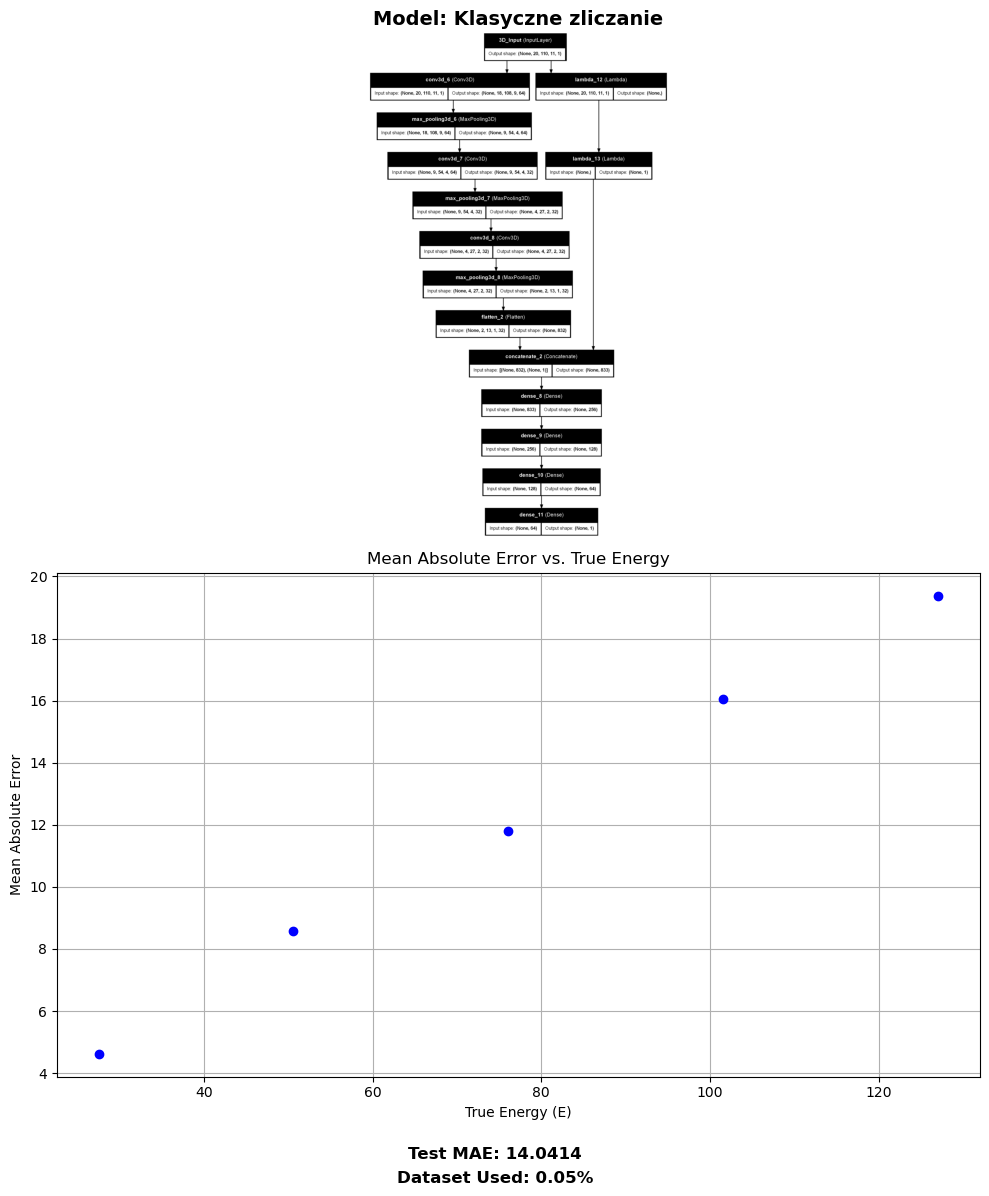

In [55]:
# --- Step 1: Load Model Diagram ---
model_img = mpimg.imread('model.png')
infographic_filename = f"{model_name}_infographic.png"
# --- Step 2: Compute Mean Absolute Error vs. True Energy ---
error = np.abs(y_true-y_pred)
num_bins = 50
bins = np.linspace(y_true.min(), y_true.max(), num_bins)
bin_indices = np.digitize(y_true, bins)
mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]

# --- Step 3: Create Infographic ---
fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows: 1 for model, 1 for graph

# --- Model Diagram ---
axs[0].imshow(model_img)
axs[0].axis('off')  # Hide axes
axs[0].set_title(f"Model: {model_name}", fontsize=14, fontweight='bold')

# --- Error Plot ---
axs[1].plot(bins[1:], mean_error, marker='o', linestyle='-', color='blue')
axs[1].set_xlabel("True Energy (E)")
axs[1].set_ylabel("Mean Absolute Error")
axs[1].set_title("Mean Absolute Error vs. True Energy", fontsize=12)
axs[1].grid(True)

# --- Step 4: Add Captions ---
fig.text(0.5, 0.03, f"Test MAE: {test_mae:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.5, 0.01, f"Dataset Used: {p:.2f}%", ha='center', fontsize=12, fontweight='bold')

# --- Save or Show Infographic ---
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit captions
plt.savefig(infographic_filename, dpi=300)
plt.show()
